In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [2]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
data_location = 'sqlite:///data.db'

In [5]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)

In [15]:
ohlc_test = ohlc.loc[ohlc.token == 'BTC']

In [6]:
def feature01(df,lookback = 10):
    return df.close/df.rolling(lookback)['open'].apply(lambda x:x[0]) -1.

In [7]:
def feature02(df,lookback = 10):
    rank = (df.close/df.open).rolling(lookback).apply(lambda x:x.argmax())
    return (lookback - rank) / lookback

In [8]:
def feature03(df,lookback = 10):
    rank = (df.close/df.open).rolling(lookback).apply(lambda x:x.argmin())
    return (lookback - rank) / lookback

In [9]:
def feature04(df,lookback = 30):
    close_max = df.close.rolling(lookback).max()
    close_min = df.close.rolling(lookback).min()
    return (df.close - close_min)/(close_max - close_min)

In [10]:
tokens = ohlc.token.unique()
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df).fillna(0),
            ret=df.close.pct_change(),
            close = df.close,
            volume = df.volume,
            feature01 = feature01(df).ewm(com= 2 ,adjust=False).mean().fillna(0),
            feature02 = feature02(df).ewm(com= 2 ,adjust=False).mean().fillna(0),
            feature03 = feature03(df).ewm(com= 2 ,adjust=False).mean().fillna(0),
            feature04 = feature04(df).ewm(com= 2 ,adjust=False).mean().fillna(0)
        )[['ts', 'vol', 'ret','close','volume','feature01','feature02','feature03','feature04']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret','close','volume','feature01','feature02','feature03','feature04'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


In [11]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [12]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [13]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

In [14]:
columns_name = ['vol', 'ret','close','volume','feature01','feature02','feature03','feature04']
pipeline = Pipeline([
    ('feature_selector', FeatureSelector([name+'_SOL'for name in columns_name])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', Ridge(alpha=0.1))
])


evaluate_model(pipeline, X, y)

-0.008781593187211084

In [15]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('feature_selector', FeatureSelector([name+'_SOL'for name in columns_name])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    #('scale', StandardScaler()),
    ('pca', PCA()),
    ('model', Ridge())
    #('model',RandomForestRegressor(n_estimators=100, random_state=0))
])

test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20, 22],
   # 'model__n_estimators' : [10, 20, 50, 100]
    'model__alpha': [0.1,0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [-0.00856799 -0.00877385         nan         nan         nan -0.00856799
 -0.00877323         nan         nan         nan -0.00856799 -0.00877249
         nan         nan         nan]
  category=UserWarning


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=211, test_size=1),
             estimator=Pipeline(steps=[('feature_selector',
                                        FeatureSelector(columns=['vol_SOL',
                                                                 'ret_SOL',
                                                                 'close_SOL',
                                                                 'volume_SOL',
                                                                 'feature01_SOL',
                                                                 'feature02_SOL',
                                                                 'feature03_SOL',
                                                                 'feature04_SOL'])),
                                       ('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
               

In [16]:
search.best_params_

{'model__alpha': 0.1, 'pca__n_components': 1}

In [17]:
best_model = search.best_estimator_

In [18]:
evaluate_model(best_model, X, y)

-0.008567990962410411

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

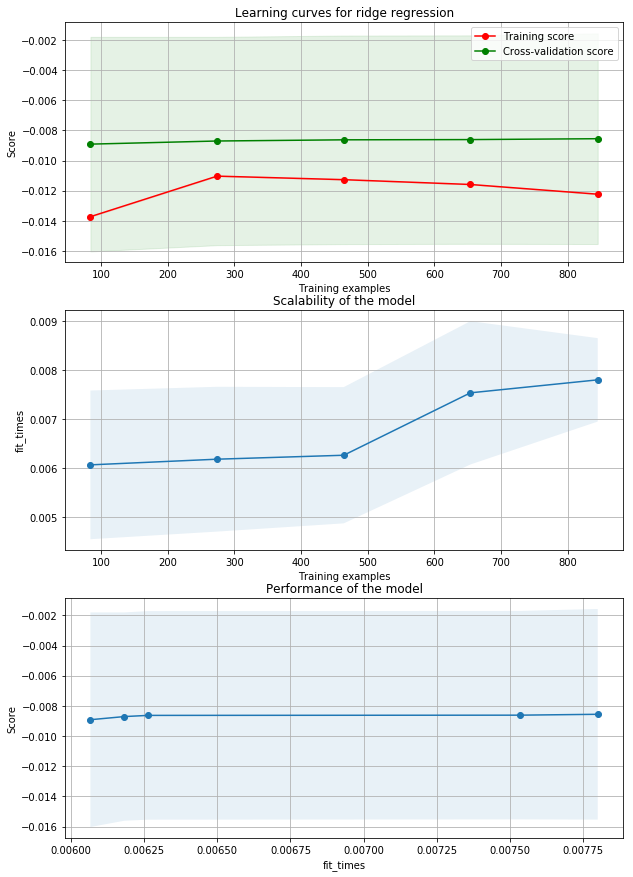

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)
